# Neural Networks for Classification

In this project, you'll be working with one of the most well-known machine learning datasets - the [Iris Data Set](https://archive.ics.uci.edu/ml/datasets/Iris) hosted at the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.html). Our goal is to train a network to identify a species of iris based on the flower's sepal length, sepal width, petal length, and petal width.

The dataset contains 50 data points for each of the three species, *Iris setosa, Iris versicolour*, and *Iris Virginica* for a total of 150 data points. 
![Iris types](img/iris_types.jpg)

### Data Description

We can load the data into a `pandas` dataframe as follows:

In [2]:
import pandas as pd

iris = pd.read_csv('data/iris.csv')

# Display the first few rows of the dataframe
iris.head()

Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa

We can see the number of records in each column to ensure all of our datapoints are complete:

In [3]:
iris.count()

Id               150
SepalLengthCm    150
SepalWidthCm     150
PetalLengthCm    150
PetalWidthCm     150
Species          150
dtype: int64

And we can see the data type for each column like so:

In [4]:
iris.dtypes

Id                 int64
SepalLengthCm    float64
SepalWidthCm     float64
PetalLengthCm    float64
PetalWidthCm     float64
Species           object
dtype: object

### Visualization

In machine learning problems, it can be helpful to try and visualize the data where possible in order to get a feel for the problem. The `seaborn` library has some great tools for this.

**Caution:** You may not have `seaborn` installed on your machine. If this is the case, use the `pip` installer from your shell (Mac OSX/Linux): `pip install seaborn`. If you're on Windows, you won't be able to install `scipy` using `pip`. You'll have to use `conda` to install the package or manually download and install a wheel yourself.



We can visualize the relationship between two features and the target classes using `seaborn`'s `FacetGrid`:

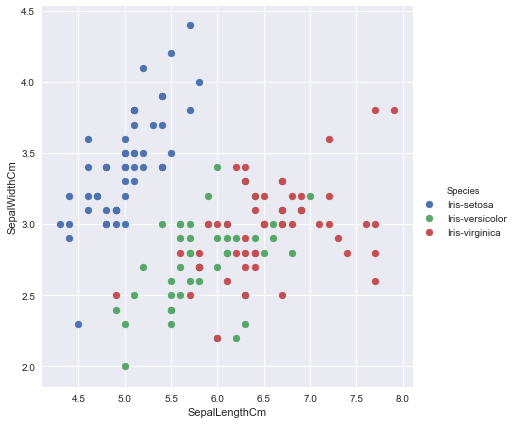

In [5]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.FacetGrid(iris, hue="Species", size=6) \
   .map(plt.scatter, "SepalLengthCm", "SepalWidthCm") \
   .add_legend()

Or we can use `pairplot` to do this for all combinations of features!

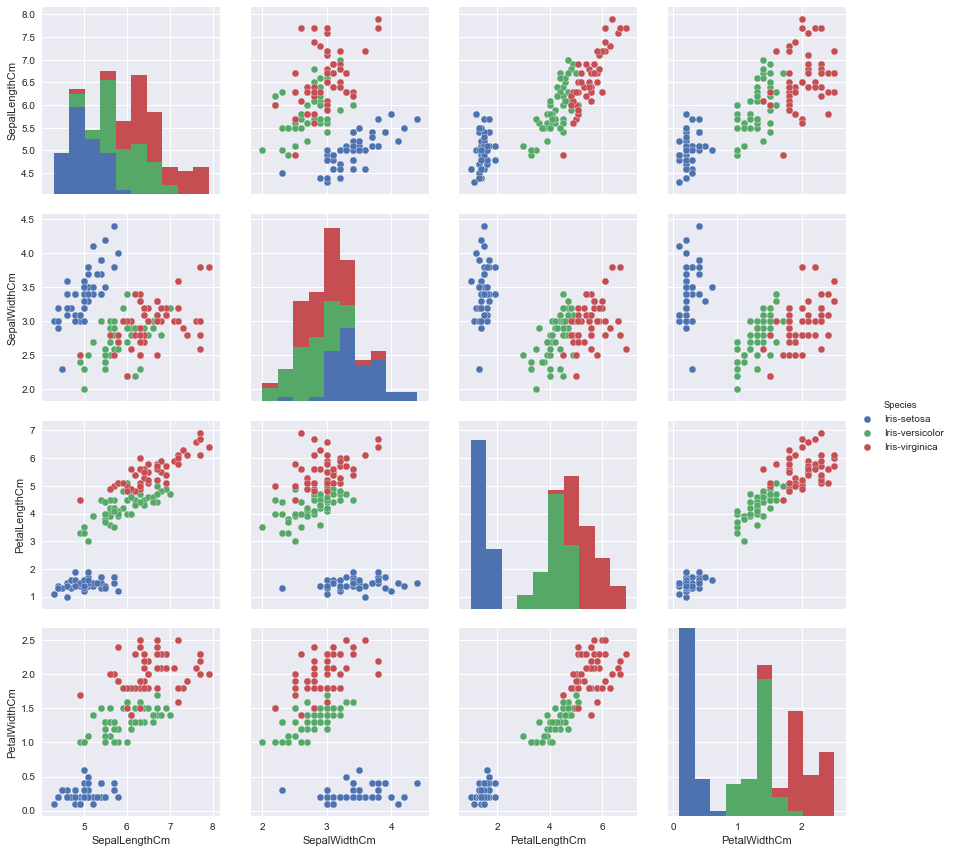

In [6]:
sns.pairplot(iris.drop("Id", axis=1), hue="Species", size=3)

From these plots we can see that *Iris setosa* is linearly separable from the others in all feature pairs. This could prove useful for the design of our network classifier.

Now that we've loaded our data and we know how it's structured, it's up to *you* to create a neural network classifier! I've given you some code to branch off of below. Good luck!

In [1]:
%matplotlib inline

# This cell can be run independently of the ones above it.

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Path for saving model data
model_path = 'tmp/model.ckpt'

# Hyperparameters 
learn_rate = 0.2980
batch_size = 10
epochs = 6

# Load the data into dataframes
# There is NO OVERLAP between the training and testing data
# Take a minute to remember why this should be the case!
iris_train = pd.read_csv('data/iris_train.csv', dtype={'Species': 'category'})
iris_test = pd.read_csv('data/iris_test.csv', dtype={'Species': 'category'})
test_features = iris_test.as_matrix()[:,:4]
test_targets = pd.get_dummies(iris_test.Species).as_matrix()

# Create placeholder for the input tensor (input layer):
# Our input has four features so our shape will be (none, 4)
# A variable number of rows and four feature columns.
x = tf.placeholder(tf.float32, [None, 4])

# Outputs will have 3 columns since there are three categories
# This placeholder is for our targets (correct categories)
# It will be fed with one-hot vectors from the data
y_ = tf.placeholder(tf.float32, [None, 3])

# The baseline model will consist of a single softmax layer with 
# weights W and bias b
# Because these values will be calculated and recalculated
# on the fly, we'll declare variables for them.
# We use a normal distribution to initialize our matrix with small random values
W = tf.Variable(tf.truncated_normal([4, 3], stddev=0.1))

# And an initial value of zero for the bias.
b = tf.Variable(tf.zeros([3]))  

# We define our simple model here
y = tf.nn.softmax(tf.matmul(x, W) + b)

#=================================================================
# And our cost function here (make sure only one is uncommented!)|
#=================================================================

# Mean Squared Error
cost = tf.reduce_mean(tf.squared_difference(y_, y))

# Cross-Entropy
# cost = tf.reduce_mean(
#     tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
#
#=================================================================

# Gradient descent step
train_step = tf.train.GradientDescentOptimizer(learn_rate).minimize(cost)

# Start a TensorFlow session
with tf.Session() as sess:

    # Initialize all of the Variables
    sess.run(tf.global_variables_initializer())
    
    # Operation for saving all variables
    saver = tf.train.Saver()
    
    # Training loop
    for epoch in range(epochs):
        avg_cost = 0.
        num_batches = int(iris_train.shape[0]/batch_size)
        
        for _ in range(num_batches):
            # Randomly select <batch_size> samples from the set (with replacement)
            batch = iris_train.sample(n=batch_size)

            # Capture the x and y_ data
            batch_features = batch.as_matrix()[:,:4]

            # get_dummies turns our categorical data into one-hot vectors
            batch_targets = pd.get_dummies(batch.Species).as_matrix()

            # Run the training step using batch_features and batch_targets
            # as x and y_, respectively and capture the cost at each step
            _, c = sess.run([train_step, cost], feed_dict={x:batch_features, y_:batch_targets})

            # Calculate the average cost for the epoch
            avg_cost += c/num_batches

        # Print epoch results
        print("Epoch %04d cost: %s" % (epoch + 1, "{:.4f}".format(avg_cost)))
    
    # If our model's most likely classification is equal to the one-hot index
    # add True to our correct_prediction tensor
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))

    # Cast the boolean variables as floats and take the mean.
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    # Calculate the percentage of correct answers using the test data
    score = sess.run(accuracy, feed_dict={x: test_features, y_: test_targets}) * 100
    print("\nThe model correctly identified %s of the test data." % "{:.2f}%".format(score))

    # Save the model data
    save_path = saver.save(sess, model_path)
    print("\nModel data saved to %s" % model_path)

Epoch 0001 cost: 0.1745
Epoch 0002 cost: 0.1067
Epoch 0003 cost: 0.1453
Epoch 0004 cost: 0.1784
Epoch 0005 cost: 0.1492

The model correctly identified 56.67% of the test data.

Model data saved to tmp/model.ckpt


[Womp womp](http://www.priceisrightfailhorn.com/). See if you can change the hyperparameters (learning rate, batch size, num_batches, etc.), the cost function (uncomment the one you'd like to use) or the structure of the network itself to yield better results!